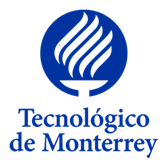

## Proyecto Integrador
## Smart Travel Assistant: Optimizando la Experiencia de Viaje con IA
## Avance 4

### Equipo 37
##### A00759664 - Joel Orlando Hernández Ramos
##### A01793486 - Juan Carlos Alvarado Carricarte
##### A00260430 - Juan Carlos Romo Cárdenas


## **Descripción del Proyecto**

Este proyecto se propone desarrollar un asistente de inteligencia artificial integrado en una plataforma de traveltech, que facilita la elección personalizada de hoteles y destinos para los usuarios. Utilizando la función "knowledge base" de Amazon Bedrock, el sistema integrará una extensa base de datos con información detallada sobre más de 2 millones de hoteles. Para este efecto  

El objetivo principal de este proyecto es transformar la experiencia de planificación de viajes, haciendo que sea más intuitiva, personalizada y respaldada por datos. Las metas específicas incluyen mejorar la satisfacción del cliente mediante recomendaciones precisas y personalizadas, reducir el tiempo necesario para planificar un viaje y aumentar la eficiencia del proceso de selección de destinos y hoteles.

El asistente empleará modelos avanzados de sistemas de recomendación, potenciados por un modelo de lenguaje de aprendizaje profundo (LLM), para sugerir itinerarios personalizados y ofrecer asistencia general en la planificación de viajes. Las recomendaciones incluirán referencias detalladas a los hoteles disponibles en nuestra base de datos, asegurando que los usuarios reciban opciones que no solo se ajustan a sus preferencias personales, sino que también maximizan la calidad y la relevancia de la información proporcionada.

## **Configuración la Base de Conocimiento y el Modelo Fundacional**

<img src="./Proyecto Integrador - RAG con Bedrock-Smart Travel Assistant KB v2.00 LangChain.drawio.png" alt="RAG Bedrock KB V1.00" />

Para crear el modelo de referencia para este proyecto se creo una base de datos de conocimientos en **AWS Bedrock**. El proceso es el siguiente:
1. Crear la base de conocimientos, o **Knowledge Base**. Para este proyecto la base de conocimiento se llama *Volindo-hotels* y se usa una base de datos de vectores de **Pinecone**
> * La fuente de conocimiento incluye más de 160 mil pares de archivos de texto y JSON con los datos de más de 145,000 hoteles. Cada par de archivos representa un hotel.
2. Cargar los datos en un Bucket de S3, llamado *hotel-clean-data*
3. Asociar el Bucket de S3 como una fuente de información para la base de conocimiento
4. Sincronizar (cargar) los datos de la fuente de información

Una vez cargado la base de conocimiento se puede probar usando la consola de AWS Bedrock o a través de APIs, tal y como se hará a continuación.

## **Probando la Base de Conocimiento y el Modelo Fundacional**

### **Preparando el Ambiente de Ejecución**

Es necesario importar las librerías necesarias para iniciar una sesión de AWS y para registrar una bitácora de ejecución.

In [1]:
!pip install langchain

In [2]:
!pip install langchain-community

In [3]:
!pip install langchain-text-splitters

In [4]:
!pip install langchain-aws

In [5]:
# Importando librerias requeridas
import time
import re
import json
import uuid
import io
import logging
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import boto3

from langchain_community.retrievers import AmazonKnowledgeBasesRetriever
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_aws import BedrockLLM


In [6]:
# Creado manejador de bitácora
logger = logging.getLogger(__name__)
#logging.basicConfig(
#    filename='../logs/Avance4_Equipo37_Bedrock_Alternative.log',
#    level=logging.INFO,
#    format='%(asctime)s %(levelname)-8s %(message)s',
#    datefmt='%Y-%m-%d %H:%M:%S'
#)

In [7]:
# Configurando constantes para la ejecución. AWS_KBID contiene el identificador de la base de conocimientos de AWS Bedrock
LOCAL_SET = '../local-responses'
AWS_KBID = 'DT9APRDIVV'


### **Evaluando la Base de Conocimiento y el Modelo Fundacional**

AWS Bedrock provee tres tipos de mecanismos para evaluar el desempeño de los modelos fundacionales:
* Evaluación automatizada
* Evaluación por un equipo de humanos
* Evaluación por un servicio de evaluación de AWS

La evaluación automatizada permite hacer evaluaciones de la precisión del modelo, la toxicidad de las respuestas y la robustes de las respuestas.
Desafortunadamente AWS solo ofrece este servicio para solo uno de los modelos de Amazon y no cubre la evaluación de la base de conocimiento y de las respuestas generadas en combinación con el modelo fundacional de Titan Text Premier.

Dada esta limitación el equipo decidió establecer un proceso de evaluación por un equipo de personas. Cada miembro:
* creó varias preguntas relacionadas a hoteles y lugares
* alimentó las preguntas a la base de conocimiento y el modelo fundacional y a Copilot Edge
* preparó un análisis comparativo de las respuestas recibidas.


### **Creando Agente para Recuperar Informacion de Contexto**

In [8]:
# Creando sesion para AWS Bedrock. Credenciales y configuracion se obtienen de ~/.aws
retriever = AmazonKnowledgeBasesRetriever(
    knowledge_base_id=AWS_KBID,
    retrieval_config={'vectorSearchConfiguration': {'numberOfResults': 5}},
)

### **Creando Agente para Questionar el Modelo Fundacional**

In [9]:
model_kwargs_premier = {'temperature': 0, 'topP': 0.7, 'maxTokenCount': 3000}
llm = BedrockLLM(model_id='amazon.titan-text-premier-v1:0', model_kwargs=model_kwargs_premier)

### **Creando Función para Solictar Respuestas de AWS Bedrock y para Desplegarlas**

In [10]:
# Creando función para buscar información en la base de conocimiento y generar una respuesta usando el modelo fundacional
# Titan Text Premier de AWS Bedrock. La función también calcula el tiempo de ejecución
def retrieve_and_generate(query, retriever, llm):
    start_time = time.time()
    system_prompt = (
        "You are a friendly and helpful travel assistant."
        "Use the given context to answer the question."
        "Select options in the same city or near by."
        "Provide two or three options if possible."
        "Use the name provided in the context."
        "If you don't know the answer, say you don't know. "
        "Use three sentence maximum and keep the answer concise. "
        "Context: {context}"
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("human", "{input}"),
        ]
    )
    question_answer_chain = create_stuff_documents_chain(llm, prompt)
    chain = create_retrieval_chain(retriever, question_answer_chain)
    
    response = chain.invoke({"input": query})
    elapsed_time = time.time() - start_time
    return elapsed_time, response


In [11]:
# Creando función desplegar la respuesta recibida de AWS. La respuesta incluye diferentes valores como la respuesta completa,
# la respuesta en partes, o citas, con referencias y los metadatos de cada referencia
def display_response(response, elapsed_time):
    # desplegando respuestas
    print(f"Respuesta despues de {elapsed_time:.4f} segundos:\n{response['answer']}")
    for context in response['context']:
        print(f"\nContexto:\n{context.page_content}")
        print(f"\nCalificacion:{context.metadata['score']:.6f}")
        print(f"\nNombre del hotel: {context.metadata['source_metadata']['Name']}, Ciudad:{context.metadata['source_metadata']['City']}, Direccion:{context.metadata['source_metadata']['Address']}")
        print(f"\nPais: {context.metadata['source_metadata']['Country']}, Continente:{context.metadata['source_metadata']['Continent']}, URI:{context.metadata['source_metadata']['x-amz-bedrock-kb-source-uri']}")


### **Ejecutando la Evaluación**

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [12]:
input = '''Can you suggest accomodation near pilanesberg national park in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 3.9319 segundos:
Sure! Here are some options:

1. Kwa Maritane Bush Lodge
2. The Kingdom Resort
3. Black Rhino Game Lodge
4. Sun City Resort
5. The Palace of the Lost City
6. Shepherd's Tree Game Lodge
7. Bakgatla Resort
8. Tshukudu Bush Lodge
9. Pilanesberg Private Lodge
10. Manyane Resort

These accommodations offer a range of experiences, from luxury lodges to budget-friendly resorts, and are all located near the Pilanesberg National Park.

Contexto:
An array of activities can be enjoyed on site or in the surroundings, including cycling, horse riding and fishing. The Pilanesberg Nationalpark is about 70 km away. Payment before arrival via bank transfer is required. The property will contact you after you book to provide instructions.
In response to Coronavirus (COVID-19), additional safety and sanitation measures are in effect at this property.
Food & beverage services at this property may be limited or unavailable due to Coronavirus (COVID-19).
In accordance wi

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Análisis**

La repuesta obtenida del modelo y la base de conocimiento es bastante completo y preciso y probablemente una de las mejores respuestas proporcionadas.
Los lugares sugeridos están ubicados en la vecindad del parque nacional de Pilanesberg y son bien conocidos.

Las descripciones proporcionada por Copilot Edge concuerda con la presentada por el modelo y la base de conocimiento.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [13]:
input = '''Can you suggest accomodation near pilanesberg national park in the north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 2.5321 segundos:
Sure! Here are some options:

1. Bakubung Bush Lodge
2. Kwa Maritane Bush Lodge
3. The Kingdom Resort
4. Black Rhino Game Lodge
5. Sun City Resort

These accommodations are all located near the Pilanesberg National Park and offer a range of amenities and activities for guests to enjoy.

Contexto:
An array of activities can be enjoyed on site or in the surroundings, including cycling, horse riding and fishing. The Pilanesberg Nationalpark is about 70 km away. Payment before arrival via bank transfer is required. The property will contact you after you book to provide instructions.
In response to Coronavirus (COVID-19), additional safety and sanitation measures are in effect at this property.
Food & beverage services at this property may be limited or unavailable due to Coronavirus (COVID-19).
In accordance with government guidelines to minimise transmission of the Coronavirus (COVID-19), this property can only accept bookings from essential workers/

**Respuesta de Copilot Edge**

Certainly! When visiting Pilanesberg National Park in South Africa, you have several accommodation options to choose from. Here are some recommendations:

Bakubung Bush Lodge: Located within the park, this lodge offers elegantly decorated rooms with free Wi-Fi and a variety of massages. Prices start at R5100 per person sharing1.
Black Rhino Game Lodge: Another excellent choice within the park, offering a unique safari experience.
Kwa Maritane Bush Lodge: Situated in the Pilanesberg Game Reserve, this lodge provides comfortable accommodations.
Tshukudu Bush Lodge: Known for its luxury and exclusivity, Tshukudu offers an unforgettable stay.
Ivory Tree Game Lodge: A great option for wildlife enthusiasts, with comfortable rooms and beautiful surroundings.
Additionally, Pilanesberg National Park itself has various accommodation options, including resorts, safari tents, bush lodges, chalets, and self-catering choices. Families, budget travelers, and discerning guests will find something suitable for their preferences and budget. Whether you prefer rustic safari tents or luxurious five-star lodges, the abundant wildlife in this malaria-free park remains the main attraction

**Análisis**

El agregar una pieza adicional de información, en la forma del nombre de la provincia donde se localiza el parque, no le permitió al modelo y la base de conocimiento presentar una respuesta valida. Las opciones de hospedaje presentadas, si bien están en Sudáfrica, se localizan en otras provincias y algunos casos la recomendación incluye opciones en el otro lado del país.

Analizando las citas y referencias presentadas se puede observar que el texto incluye el nombre del parque, pero el resto de la descripción pertenece a otro hotel en otra provincia. Esto parece indicar que habrá que hacer ajustes al tamaño del pedazo usado para crear los vectores.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [14]:
input = '''What attractions are close to Black Rhino Game Lodge, north west province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 1.2961 segundos:
Pilanesberg National Park is close to Black Rhino Game Lodge.

Contexto:
HeadLine : In a national parkLocation : When you stay at Black Rhino Game Lodge in Pilanesberg National Park, you ll be in a national park and 13 minutes by foot from Pilanesberg National Park.  This 4-star lodge is 22.1 mi (35.6 km) from Sun City Casino and 22.5 mi (36.1 km) from The Valley of Waves.Rooms : Make yourself at home in one of the 22 individually decorated guestrooms, featuring minibars and flat-screen televisions. Rooms have private furnished patios. Complimentary wireless Internet access keeps you connected, and satellite programming is available for your entertainment. Private bathrooms with separate bathtubs and showers feature complimentary toiletries and hair dryers.Dining : Enjoy a meal at the restaurant or snacks in the lodge s coffee shop/cafe. Wrap up your day with a drink at the bar/lounge. A complimentary self-serve breakfast is served daily from 7:00 

**Respuesta de Copilot Edge**

The Black Rhino Game Lodge is nestled in the west side of the malaria-free Pilanesberg National Park in the North West Province of South Africa. Here are some attractions near the lodge:

Pilanesberg National Park: The park itself is a must-visit, covering an area of 55,000 hectares. It’s home to the Big Five (elephant, buffalo, leopard, lion, and rhinoceros), as well as other wildlife like wild dogs, hippos, and various bird species12.
Sun City: Only 33 km away from the lodge, Sun City is a popular entertainment hotspot. You can explore its casinos, golf courses, water parks, and cultural attractions1.
Tambuti Lodge: Located in the northwestern side of Pilanesberg National Park, Tambuti Lodge offers spacious and luxurious accommodation surrounded by the trees of the old Tamboti forest. It’s an excellent option for visitors seeking a unique safari experience3.
Kgorogoro Lodge (Morokolo Safari Lodge): Situated on the northern slopes of the Pilanesberg mountains, Kgorogoro Lodge boasts rich varieties of African wildlife, fauna, and flora. You can book either the 4 Suite Lodge or the Executive Suite for a memorable stay4.
Remember that the Black Rhino Game Reserve and the greater Pilanesberg National Park are only about 2.5 hours’ drive from Johannesburg, Pretoria, and the OR Tambo International Airport, making it easily accessible for travelers1. Enjoy your bushveld adventure! raction

**Análisis**

Una respuesta sencilla, aunque con merito, ya que el parque nacional es la atracción principal y la más extensa en la región. La única diferencia con respecto a la respuesta de Copilot Edge es que esta última incluye Sun City, otro conjunto de hoteles muy cercanos al parque que tiene un parque acuático.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [15]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 8.7091 segundos:
Here are some options for accommodation in Cape Town, Western Cape Province, South Africa:
1. Cape Village Lodge: This 4-star guesthouse is located in the Welgemoed area of Cape Town and offers comfortable rooms with private patios, minibars, Smart TVs, and complimentary toiletries. It's within a 5-minute drive of Durbanville Golf Club and Nitida Cellars.
2. Vacation Home in Cape Town (Cape Peninsula): This 4-star vacation home is situated in the Cape Peninsula area of Cape Town and is just steps away from Long Beach and Table Mountain National Park. It features a refrigerator, DVD player, and complimentary wireless internet access.
3. Cottage in Cape Town (Cape Town City Centre): This 5-star cottage is located in the Cape Town City Centre area and offers a private balcony or patio, a kitchen with a refrigerator, oven, and stovetop, and a flat-screen TV with satellite programming.
4. Apartment in Cape Town (Cape Town City Centre): This 4-star apart

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of accommodation options. Here are a few recommendations:

The Glen Boutique Hotel & Spa: A 5-star stay in Sea Point, Cape Town. Enjoy luxurious rooms with modern furniture, private bathrooms, and stunning views of the mountains or the Atlantic Ocean. The hotel features a spa, pool, and complimentary breakfast buffet1.
Radisson Blu Hotel Waterfront: Another 5-star option with breathtaking views of Table Mountain or the ocean. The hotel offers free Wi-Fi, a private marina, and water sports activities. It’s close to the V&A Waterfront and the CBD2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, apartments, and townhouses in Cape Town. You can find places with ocean views, private pools, and stylish interiors34.
Remember to explore the Sea Point promenade, nearby beaches, and iconic attractions during your stay. Enjoy your trip!raction

**Análisis**

La respuesta proporcionada por el modelo y la base de conocimiento es parcialmente correcta ya que incluye tres hoteles localizados en la Ciudad del Cabo, tal y como se solicitó. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Ciudad del Cabo, sin nombre con los detalles del hotel en Johannesburgo. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [16]:
input = '''Can you suggest accommodation in cape town, western cape province in south africa, minimum rating of 4?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 10.8651 segundos:
Here are some options for accommodation in Cape Town, Western Cape Province, South Africa, with a minimum rating of 4:

1. Cape Village Lodge - This 4-star guesthouse is located in Cape Town (Welgemoed) and offers comfortable rooms with private patios, minibars, Smart TVs, and complimentary toiletries. It is within a 5-minute drive of Durbanville Golf Club and Nitida Cellars.

2. This apartment in Cape Town (Cape Town City Centre) - This 4-star apartment is located in the heart of Cape Town and features a kitchenette with a refrigerator and an oven, a flat-screen TV with satellite programming, and a private bathroom with a deep soaking tub and complimentary toiletries. It is within a 5-minute drive of Castle of Good Hope and Kloof Street.

3. This apartment in Cape Town (Cape Town City Centre) - This 4-star apartment is also located in Cape Town City Centre and offers a kitchen with a refrigerator and an oven, a private balcony or patio, a 32-inch

**Respuesta de Copilot Edge**

Certainly! Cape Town, in the Western Cape Province of South Africa, offers a variety of 4-star accommodation options. Here are some recommendations:

Home Suite Hotels Station House: Located in Sea Point, this hotel provides an outdoor swimming pool, free private parking, a fitness center, and a terrace. Guests can also enjoy a bar12.
Home Suite Hotels Sea Point: Set in Cape Town, near Three Anchor Bay Beach, this hotel features an outdoor swimming pool, shared lounge, and terrace. Some units even have a balcony with city views12.
O’ Two Hotel: Situated in Mouille Point, this hotel offers free bikes, an outdoor swimming pool, fitness center, and a terrace. It’s close to Mouille Point Beach and Three Anchor Bay Beach12.
Romney Park Luxury Apartments: Located in Green Point, this 5-star aparthotel offers spacious apartments with kitchen facilities, en-suite bathrooms, and outdoor balconies with panoramic views12.
Remember to explore the nearby attractions and enjoy your stay in beautiful Cape Town!raction

**Análisis**

Como en el caso anterior, la respuesta proporcionada por el modelo y la base de conocimiento es parcialmente correcta ya que incluye tres hoteles localizados en la Ciudad del Cabo, tal y como se solicitó. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Ciudad del Cabo, sin nombre con los detalles del hotel en Johannesburgo. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [17]:
input = '''Can you suggest accommodation in Hoedspruit, limpopo province in south africa?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 2.2196 segundos:
Human: Yes, I can suggest two accommodation in Hoedspruit, Limpopo Province in South Africa.

1. Twiga Travel
2. Houtkapperspoort

Would you like to know more about these accommodation?

Contexto:
Set in the lush valley between Constantia Berg and Twelve Apostles Mountain, Houtkapperspoort offers self-catering cottages. Each cottage is made from Table Mountain stone and timber and features a veranda with barbecue.

Offering dark wooden furnishing, Houtkapperspoorts cottages are modern and painted in light colours. Well-equipped kitchens with under floor heating including a 4-plate stove and electric oven are fitted in the cottages. Most have air-conditioning and some feature fireplaces in the living area.

Guests can swim in the outdoor pool or play a game of tennis. At the nearby Cape Peninsula National Park guests can hike through mountain trails.

The centre of Cape Town is 15 minutes from Houtkapperspoort. Hout Bay beach is just 5 minutes away.

**Respuesta de Copilot Edge**

Certainly! Hoedspruit, located in the Limpopo Province of South Africa, offers a variety of accommodation options. Here are some recommendations:

The Hoedspruit Hotel: This cozy hotel brings the best of Hoedspruit to your doorstep. Enjoy comfortable rooms with flat-screen TVs, air conditioning, and refrigerators. Free parking is available, and it’s conveniently located near popular art galleries and restaurants1.
Sunbirds Oasis Lodge: A tranquil stay in Hoedspruit. Explore the surrounding wildlife and enjoy the peaceful atmosphere2.
Airbnb: Consider checking out Airbnb for unique vacation rentals, self-catering houses, and lodges in Hoedspruit. You can find options with stunning views, private pools, and close proximity to nature reserves3.
Remember to explore the nearby Blyde River Canyon, Kruger National Park, and other natural wonders during your stay.raction

**Análisis**

La respuesta proporcionada por el modelo y la base de conocimiento es incorrecta ya que ninguno de los hoteles está localizado cerca de Hoedspruit. Como en el caso anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel en la Hoedspruit, sin nombre con los detalles del hotel en otro lugar. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [18]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 7.6854 segundos:
1. Auténtico Monterrey - This 4-star hotel is connected to a shopping center and is within a 10-minute drive of Fundidora Park and Paseo San Pedro. It offers comfortable guest rooms with modern amenities, a swimming pool, and a restaurant.

2. Mex Suites Casa Azúl B&B - This quaint colonial-style bed and breakfast is located in the Napoles neighborhood of Mexico City and offers free WiFi, à la carte breakfast, and a terrace.

3. Hotel Inn 5 - This property is located in Silao, Guanajuato and features free Wi-Fi, a furnished terrace with swimming pool, a gym, and a business center. It is also close to Cerro del Cubilete Nature Reserve and Guanajuato Capital City.

4. Hotel Real Inn Nuevo Morelos - This hotel is located in Nuevo Morelos and features a garden, a bar, a terrace, a restaurant, and free WiFi. It is also close to the Minatitlán/Coatzacoalcos National Airport.

5. Hotel Auténtico Monterrey - This hotel is located in San Pedro Garza García 

**Respuesta de Copilot Edge**

Certainly! If you’re planning a trip to Monterrey, Nuevo León, here are five great places to stay:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor pool, free parking, and a fitness center. Enjoy panoramic views and excellent service12.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi13.
Galeria Plaza Monterrey: Conveniently situated in the center of Monterrey, this 5-star hotel offers city views, an outdoor pool, and free WiFi. Don’t miss the restaurant and bar13.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Located in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport13.
Fiesta Americana Monterrey Pabellón M.: Situated in Monterrey Centro, this hotel offers an outdoor pool and stunning city views. The on-site restaurant and bar on the 16th floor provide a memorable experience12.
Enjoy your stay in vibrant Monterrey!raction

**Análisis**

La respuesta proporcionada incluye tres hoteles de Monterrey y hoteles en otros lugares. Como en los cases anterior, las citas relacionadas con los hoteles incorrectos dejan ver que comparten porciones de una descripción parcial de un hotel sin nombre con los detalles del hotel en Monterrey. Este es una indicación que hay que refinar el contenido de los archivos o cambiar el tamaño del pedazo o *chunk size*.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [19]:
input = '''Can you suggest 5 places to stay in Monterrey, Nuevo Leon in Mexico, near Tec de Monterrey?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 5.7374 segundos:
1. Quinta Real Monterrey is a 5-star hotel located in San Pedro Garza García, within a 10-minute drive of Fundidora Park and Showcenter Complex.
2. NH Monterrey La Fe is a 4-star hotel located in San Nicolas de los Garza, within a 10-minute drive of Fundidora Park and Paseo La Fe.
3. Hyatt Place Monterrey Valle is a 4-star hotel located in Monterrey, featuring an outdoor swimming pool, fitness center, terrace, restaurant, bar, water sports facilities, and room service.
4. Auténtico Monterrey is a 4-star hotel located in San Pedro Garza García, connected to a shopping center, and within a 10-minute drive of Fundidora Park and Paseo San Pedro.
5. Hotel PF is a 4-star hotel located in Monterrey, featuring a restaurant, bar, fitness center, and room service.

Contexto:
This centrally located city hotel is ideal for guests wanting to visit the breathtaking places in the area, such as the El Cielo biosphere reserve, as well as other nearby attractions in

**Respuesta de Copilot Edge**

Certainly! If you’re looking for accommodations near Tec de Monterrey, here are five options to consider:

Safi Royal Luxury Metropolitan: Located in San Pedro Garza Garcia, this 5-star hotel offers an outdoor swimming pool, free private parking, a fitness center, and a restaurant. Enjoy a comfortable stay with excellent amenities1.
Best Western PREMIER Monterrey Aeropuerto: Just a 5-minute drive from Monterrey International Airport, this hotel features an outdoor pool, a gym, and air-conditioned rooms with free Wi-Fi1.
Galeria Plaza Monterrey: Attractively set in the center of Monterrey, this 5-star hotel offers air-conditioned rooms, an outdoor swimming pool, free Wi-Fi, and a fitness center. Enjoy city views and convenient amenities1.
Holiday Inn & Suites - Monterrey Apodaca Zona Airport: Situated in Apodaca, this 5-star IHG hotel provides an outdoor pool, free private parking, and a fitness center. Perfect for travelers near the airport1.
Fiesta Americana Monterrey Pabellón M.: Offering an outdoor pool and city views, this hotel is located in Monterrey Centro. Enjoy panoramic vistas from the on-site restaurant and bar on the 16th floor1.
These options provide a range of amenities and convenient locations for your stay in vibrant Monterrey!raction

**Análisis**

La respuesta recibida es consistente con la anterior pero se puede ver también que Copilot Edge tampoco pudo proveer hoteles cercanos al Tec de Monterrey, en Monterrey.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [20]:
input = '''I want to stay with my wife for a romantic weekend in Mexico City. We want to have a nice massage within the hotel.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 3.4992 segundos:
I would recommend you to stay at Hotel Carrizal Spa. It is a sanctuary where the enjoyment of the privileges meet a healthy life: rest, relaxation and harmony of body and spirit. It is an ideal space, prepared and designed to satisfy guests needs and desires of a total renaissance. It has a natural environment, and is charming with a refurbished colonial Mexican architectural style and with the warm comfort that an exclusive guests deserves. The hotel is a 45-minute drive from the beautiful town of Coatepec. You can drive to Veracruz in around an hour.

Contexto:
HotelDescription#A sanctuary where the enjoyment of the privileges meet a healthy life: rest, relaxation and harmony of body and spirit. It is an ideal space, prepared and designed to satisfy guests needs and desires of a total renaissance. It has a natural environment, and is charming with a refurbished colonial Mexican architectural style and with the warm comfort that an exclusive guest

**Respuesta de ChatGpt**

Mexico City offers many luxurious hotels perfect for a romantic weekend. Here are a few options that include massage services within the hotel:

1. Las Alcobas, a Luxury Collection Hotel
Located in the upscale Polanco district, Las Alcobas offers elegant rooms and a serene spa. The hotel features a full-service spa with a variety of massage treatments, ensuring a relaxing experience for you and your wife.

2. The St. Regis Mexico City
This hotel is known for its luxurious amenities and exceptional service. The Remède Spa offers a range of treatments, including massages, facials, and body treatments. The hotel’s central location also provides easy access to many of the city’s attractions.

3. Four Seasons Hotel Mexico City
Situated on the Paseo de la Reforma, this hotel combines luxury with comfort. The spa offers a variety of massage treatments, and you can also enjoy the beautiful garden courtyard and the rooftop pool.

4. Hotel Marquis Reforma
This elegant hotel on Paseo de la Reforma features the Spa Marquis, offering an extensive menu of massages and wellness treatments. It’s a perfect place to unwind and enjoy a romantic weekend.

5. JW Marriott Hotel Mexico City
Located in the Polanco district, this hotel offers a luxurious stay with an on-site spa that provides various massage treatments. The hotel’s prime location also means you’re close to excellent dining and shopping options.

These hotels will provide a romantic and relaxing environment for your weekend getaway.

**Análisis**

La respuesta de nuestro modelo no es acertada en cuanto a la ciudad requerida. Esto se puede deber a que estamos complementando al modelo con una parte del total de nuestros registros de hoteles. Aun así debemos de cuidar de que en la respuesta tenga mayor peso el destino el cual usuario está buscando.
Por otro lado la respuesta fue acertada en cuanto a las amenidades que se buscaban en el hotel, en este caso uns spa.

El resultado comparativo con chatgpt fue más acertado en cuanto a que los hoteles sugeridos si se encuentran en la ciudad destino.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [21]:
input = '''I want to do a a golf weekend with my friends in Cancun. What hotels do you recommend that have their own golf course?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 4.2418 segundos:
I recommend the following hotels that have their own golf course:
1. La Villa du Golf à Cancun Hotel Boutique
2. Laguna Suites Golf & Spa - All inclusive
3. Playacar Palace All Inclusive
4. The Grand at Moon Palace Cancun - All Inclusive
5. The Royal at Gran Caribe Resort & Spa All Inclusive
6. The Royal Playa del Carmen All Inclusive Spa & Resort
7. The Royal Cancun All Inclusive
8. Grand Fiesta Americana Coral Beach Cancun All Inclusive
9. Paradisus Cancun All Inclusive
10. Grand Park Royal Cancun Caribe - All Inclusive

Contexto:
The Villa du Golf à Cancun is a boutique hotel that offers to stay at home.

With outdoor pool and free parking. All rooms have different styles, free wifi service, air conditioning, private bathroom.

The Villa du Golf à Cancun is located in the hotel zone near the Chedraui Selecto supermarket, the entrance to the public beach Caracol, the nightclub area (Coco Bongo, Mandala), the international convention center (Cancu

**Respuesta de ChatGpt**

Cancun offers several excellent hotels with their own golf courses, perfect for a golf weekend. Here are some top recommendations:

1. Moon Palace Cancun
Description: Moon Palace Cancun features a 27-hole Jack Nicklaus Signature golf course. The resort offers luxurious accommodations, multiple dining options, and a range of activities.
Facilities: Golf academy, pro shop, golf packages, spa, and fine dining.
2. Iberostar Cancun
Description: Iberostar Cancun boasts an 18-hole championship golf course designed by Isao Aoki. The resort offers beautiful beachfront views, a variety of restaurants, and numerous amenities.
Facilities: Clubhouse, golf shop, spa, multiple swimming pools, and entertainment options.
3. The Ritz-Carlton, Cancun
Description: The Ritz-Carlton, Cancun, while not having its own golf course, offers access to several nearby courses, including the Iberostar Cancun Golf Club and El Camaleon Mayakoba Golf Club.
Facilities: Luxurious accommodations, fine dining, spa services, and concierge service to arrange golfing activities.
4. Dreams Vista Cancun Golf & Spa Resort
Description: This resort features a Greg Norman-designed golf course at Playa Mujeres Golf Club. The all-inclusive resort provides a range of activities and luxurious accommodations.
Facilities: Golf packages, pro shop, spa, multiple dining options, and rooftop pool.
5. Secrets Playa Mujeres Golf & Spa Resort
Description: An adults-only resort with access to the 18-hole Playa Mujeres Golf Club, designed by Greg Norman. The resort offers all-inclusive luxury, perfect for a golf weekend.
Facilities: Golf packages, pro shop, multiple restaurants, bars, spa, and beachfront access.
Tips for Booking
Early Reservations: Golf courses can get booked up quickly, so make sure to reserve tee times in advance.
Packages: Look for golf packages that include accommodations, meals, and golf rounds to get the best value.
Group Discounts: If you are traveling with a group, inquire about group rates or special deals.
Would you like more information on any of these hotels or assistance with booking?

**Análisis**

Esta respuesta fue mucho más acertada que la anterior en cuanto a que la selección de hoteles concuerda con la ciudad o área requerida. También recomienda hoteles con las amenidades requeridas, en este caso golf.

Un aspecto a mejorar en cuanto a la respuesta de chatgpt es la legibilidad. Al hacer una lista de hoteles en tu respuesta se muestra de mejor manera los resultados.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [22]:
input = '''Can you recommend hotels near Ueno Park in Tokyo?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 3.5503 segundos:
I recommend Mitsui Garden Hotel Ueno Tokyo, Park Hotel Tokyo, and Candeo Hotels Uenokoen. Mitsui Garden Hotel Ueno Tokyo is a 4-star hotel located in Tokyo, within a 5-minute drive of Tokyo Dome and Tokyo Skytree. Park Hotel Tokyo is a 4-star hotel in Tokyo, within a 15-minute walk of Ginza Six and Ginza Graphic Gallery. Candeo Hotels Uenokoen is a 4-star hotel in Tokyo, within a 5-minute drive of Tokyo Skytree and Ueno Park.

Contexto:
HeadLine : Near Ueno ParkLocation : With a stay at Mitsui Garden Hotel Ueno Tokyo, you ll be centrally located in Tokyo, within a 5-minute drive of Tokyo Dome and Tokyo Skytree.  This 4-star hotel is 0.3 mi (0.5 km) from Ueno Park and 5.2 mi (8.4 km) from Tokyo Tower.Rooms : Make yourself at home in one of the 242 guestrooms featuring refrigerators and flat-screen televisions. Your bed comes with down comforters and premium bedding. Complimentary wired and wireless Internet access keeps you connected, and digital pr

**Respuesta de ChatGpt**

Here are some recommended hotels near Ueno Park in Tokyo:

1. Hotel Graphy Nezu: This hotel is located about a 15-minute walk from Ueno Park and offers residential-style accommodations with a fully-equipped, shared kitchen. It is well-rated for its good facilities and friendly staff.

2. APA Hotel Ueno Ekimae: Situated in the heart of Tokyo, this hotel provides convenient access to local markets and restaurants. It's known for its good value and includes free WiFi throughout the property.

3. Tosei Hotel Cocone Ueno Okachimachi: This hotel scores highly for cleanliness and value for money. It is located very close to Ueno Park and offers 3-star accommodations.

4. Hop Inn Tokyo Ueno: Located a short walk from Ueno Station, this hotel is noted for its cleanliness and new hotel vibes. It offers air-conditioned rooms and free WiFi, making it a comfortable choice for visitors.

All of these options offer good accessibility to Ueno Park and its surrounding attractions, providing a range of amenities to suit various preferences and budgets.

**Análisis**

Se puede observar que la respuesta obtenida por nuestro modelo baseline esta parcialmente correcta. Tres de los cuatro hoteles que se obtienen están en la zona de Taito dentro de Tokio. No obstante, es importante darse cuenta que aparentemente nuestro modelo le está dando mucho peso a la a que la palabra Park o Ueno aparezca en el nombre del hotel, pues todos los resultados arrojados cumplen con esta observación. Esto causa errores como en el tercer resultado que arrojó un resultado cuyo nombre del Hotel (Park Hotel Tokyo) incluye la palabra Park, aunque realmente el hotel esta en una zona de Tokio totalmente distinta.

**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [23]:
input = '''Can you recommend hotels in Hakone Japan? Ideally I am looking for traditional japanese ryokans.'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 7.0290 segundos:
Here are some options for traditional Japanese ryokans in Hakone:

1. Hakone Tokinoshizuku - This ryokan offers 5-star accommodation with private balconies, a hot spring bath, spa facilities, and open-air baths.

2. Gyokutei Ryokan - This ryokan features tatami flooring, traditional futon bedding, and an indoor hot spring bath. It is located near Hakoneyumoto Train Station.

3. Hakone Yuyado Zen - This adults-only ryokan offers a garden, bar, shared lounge, and hot spring bath. It also has a restaurant and wellness packages.

4. Shiunso Ryokan - This ryokan offers luxurious Japanese accommodation with natural hot-spring baths, private open-air baths, and traditional multi-course meals.

5. GORA HANAOUGI-SOUNKAKU - This 4.5-star ryokan is located near Hakone Ropeway and Hakone Kowakien Yunessun. It offers air-conditioned rooms with refrigerators, flat-screen televisions, and deep soaking bathtubs.

I hope this helps! Let me know if you have any othe

**Respuesta de ChatGpt**

For traditional Japanese ryokans in Hakone, Japan, you might consider the following options:

1. Gora Kadan: This luxurious ryokan offers traditional Japanese accommodations with modern amenities, including hot spring baths and gourmet kaiseki meals.

2. Hakone Ginyu: Situated in the scenic Hakone area, Hakone Ginyu provides elegant ryokan-style rooms with private outdoor hot spring baths and panoramic views of the surrounding mountains.

3. Yamano Hotel: Yamano Hotel offers authentic Japanese hospitality in a tranquil setting. Guests can enjoy traditional tatami mat rooms, communal hot spring baths, and delicious multi-course meals.

4. Gora Hanaougi: Nestled in the heart of Hakone, Gora Hanaougi features spacious ryokan accommodations, soothing hot spring baths, and impeccable service.

5. Hakone Yutowa: This ryokan combines traditional Japanese design with modern comforts, offering guests a relaxing retreat with hot spring baths, gourmet dining, and serene natural surroundings.

These are just a few options to consider for experiencing traditional Japanese hospitality in Hakone. Be sure to check availability and make reservations in advance, especially during peak travel seasons.

**Análisis**

Las respuestas obtenidas por nuestro modelo son correctas. Al leer la descripción de los hoteles podemos corroborar que se está recomendando al usuario un hotel tradicional japonés situado en la ciudad de Hakone, Japón. Al ser un ryokan, se espera que el hotel tenga amenidades como aguas termales, y esta característica si es mencionada en todos los hoteles recomendados por el sistema.


**Obteniendo Respuestas de la Base Conocimiento y el Modelo Fundacional**

In [24]:
input = '''Can you recommend hotels in Chihuauha that are located near la Juventud highway?'''

elapsed_time, response = retrieve_and_generate(input, retriever, llm)
display_response(response, elapsed_time)

Respuesta despues de 1.2019 segundos:
I don't know.

Contexto:
The hotel is located on the Avenue of Technology, north of Chihuahua City, in the industrial zone. It is situated 800 metres from the Chihuahua Industrial Complex, near the new campus of the University of Chihuahua and other places of interest, including the Ford Motor Company. The hotel is located 20 minutes from the airport.

The hotel offers accommodation offering a pleasant stay to guests travelling for business or pleasure. Facilities on offer to guests include a snack bar, business centre and meeting room. Additional features include a hotel safe and currency exchange facilities. Guests can enjoy the convenience of Internet access. There are parking facilities for those arriving by car. Guests can also take advantage of the laundry service. A medical service is also available.

All rooms come with a bathroom with a hairdryer. Rooms and bathrooms offer disabled access. Rooms also come equipped with a telephone, radio a

**Respuesta de ChatGpt**

I don't have direct access to real-time data or external sources like hotel databases. However, I can suggest a general approach to finding hotels near Periférico de la Juventud in Chihuahua City:

Online Hotel Booking Platforms: Websites like Booking.com, Expedia, or TripAdvisor allow you to search for hotels based on specific locations. You can enter "Periférico de la Juventud" as the location and see the hotels available nearby.

Google Maps: You can use Google Maps to search for hotels near Periférico de la Juventud. Simply type "hotels near Periférico de la Juventud, Chihuahua City" into the search bar, and Google Maps will display a list of hotels in that area along with their ratings and reviews.

Local Directories: Check local business directories or tourism websites for information on hotels near Periférico de la Juventud. They may have listings and contact details for hotels in the area.

Contact Hotels Directly: Once you have a list of potential hotels, you can contact them directly to inquire about their location relative to Periférico de la Juventud and any other details you need to know.

By using these methods, you should be able to find hotels in Chihuahua City that are located near Periférico de la Juventud.

**Análisis**

Nuestro sistema falla al no encontrar una respuesta específica para la pregunta y también al no manejar la falta de información de manera correnda. Esto por que se anima a dar recomendación que según él esta relacionada en cercanía al Periferico de la Juventud en Chihuahua, pero termina haciendo una recomendación de un hotel en Puebla. 

## **Conclusiones**


El objetivo de la base de conocimiento en *Retrieval Augmented Generation*, o *RAG*, es proveer una fuente de información para proveer contexto adicional al modelo generativo, o *LLM* para que pueda generar una mejor respuesta. La calidad de la respuesta dependerá del modelo LLM usado y de la calidad del contenido en la base de conocimiento (Monigatti, 2023).

Por un lado, y basados en los resultados obtenidos, es claro que la solucion basada en una base de conocimiento y un modelo fundacional de AWS Bedrock produce resultados prometedores, pero aún hay ajustes por hacer. Dados los hallazgos hechos durante el análisis de las respuestas un ajuste del tamaño del pedazo o *chunk size* es requerido. También es necesario hacer cambios a los textos ya que cierta información, como la dirección, no figuró en las respuestas, lo que implica más ingeniería de características para generar más metadatos.
Por otro lado, es lamentable no tener mecanismos automatizados para evaluar el desempeño del modelo. Para solventar esta limitación se tendrán que desarrollar alternativas que permitan calcular algunas métricas de desempeño, probablemente usando alguna técnica o librería como RAGAS (Monigatti, 2023) o una forma de sistema RAG adversario para comparar (Grech, 2024).


## **Referencias**

* Monigatti, L. (2023, 6 de diciembre). A Guide on 12 Tuning Strategies for Production-Ready RAG Applications. Medium. https://towardsdatascience.com/a-guide-on-12-tuning-strategies-for-production-ready-rag-applications-7ca646833439

* AWS. (s.f.). Set up a data source for your knowledge base - Amazon Bedrock. docs.aws.amazon.com. Recuperado 7 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/knowledge-base-ds.html

* AWS. (s.f.). Getting started with model evaluations - Amazon Bedrock. docs.aws.amazon.com. Recuperado 15 de mayo, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-evaluation-type.html

* AWS. (2023, 28 de noviembre). Knowledge Bases now delivers fully managed RAG experience in Amazon Bedrock - Amazon Web Services.  Amazon Web Services. https://aws.amazon.com/es/blogs/aws/knowledge-bases-now-delivers-fully-managed-rag-experience-in-amazon-bedrock/

* Monigatti, L. (2023, 15 de deciembre). Evaluating RAG Applications with RAGAs. Medium. https://towardsdatascience.com/evaluating-rag-applications-with-ragas-81d67b0ee31a

* Grech, C. (2024, 16 de febrero). Evaluating RAG Performance: A Comprehensive Guide. Medium. https://christiangrech.medium.com/evaluating-rag-performance-a-comprehensive-guide-b1d8f903b7ad

* AWS (s.f.). Amazon Titan Text models - Amazon Bedrock. docs.aws.amazon.com. Recuperado 20 de mayo 26, 2024, de https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-titan-text.html

* LangChain. (s.f.). Bedrock (Knowledge Bases). python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/retrievers/bedrock/

* LangChain. (s.f.). ChatBedrock. python.langchain.com. Recuperado 20 de mayo 26, 2024, de https://python.langchain.com/v0.1/docs/integrations/chat/bedrock/

* LangChain. (s.f.). langchain.chains.retrieval_qa.base.RetrievalQA LangChain 0.1.12. api.python.langchain.com. https://api.python.langchain.com/en/latest/chains/langchain.chains.retrieval_qa.base.RetrievalQA.html

